# Testing DEMV on _Wine Quality_ Dataset

- Label: `quality`
- Positive label: `quality=6`
- Unprivileged group: `alcohol=0 (<=10) & type=1 (white)`

Source: [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from demv import DEMV
from utils import *

import warnings
warnings.filterwarnings('ignore')

#patch_sklearn()
sns.set_style('whitegrid')

In [2]:
def load_data():
  red = pd.read_csv('data2/winequality-red.csv', sep=';')
  red['type'] = 0
  white = pd.read_csv('data2/winequality-white.csv', sep=';')
  white['type'] = 1
  data = red.append(white)
  data.drop(data[(data['quality']==3)|(data['quality']==9)].index, inplace=True)
  data.loc[data['alcohol'] <= 10, 'alcohol'] = 0
  data.loc[(data['alcohol'] > 10) & (data['alcohol'] != 0), 'alcohol'] = 1
  return data

In [3]:
data = load_data()

<AxesSubplot:>

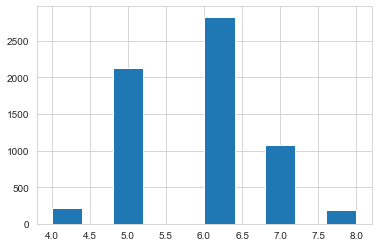

In [4]:
data['quality'].hist()

In [5]:
data = data.loc[ data.quality != 8 ]

In [6]:
label = 'quality'
sensitive_variables = ['alcohol', 'type']
protected_group = {'alcohol': 0, 'type': 1}
positive_label = 6

In [7]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased dataset

In [8]:
model, bias_metrics = cross_val(pipeline, data, label, protected_group, sensitive_variables,positive_label=positive_label)

In [9]:
print_metrics(bias_metrics)

Equalized odds:  0.756  +-  0.16
Disparate impact:  0.535  +-  0.049
Zero one loss:  0.15  +-  0.099
Accuracy score:  0.561  +-  0.01


## DEMV dataset

In [10]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [11]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_variables, positive_label=positive_label, debiaser=demv)

In [12]:
print_metrics(demv_metrics)

Equalized odds:  0.421  +-  0.284
Disparate impact:  0.865  +-  0.067
Zero one loss:  0.106  +-  0.053
Accuracy score:  0.517  +-  0.013


## DEMV Evaluation

In [13]:
demv.get_iters()

371

In [14]:
metrics = eval_demv(76, demv.get_iters(), data.copy(), pipeline, label,
                    protected_group, sensitive_variables, positive_label=positive_label)


##  Blackbox Postprocessing 

In [15]:
data = data.sample(frac=1).reset_index(drop=True)

In [16]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_variables, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0065  0.0000
5  0.3626  0.7164
6  0.3980  0.5000
7  0.0231  0.1429

1
      fpr     tpr
4  0.0000  0.0526
5  0.1562  0.5821
6  0.5568  0.7241
7  0.0421  0.2432


And loss is 0.4640


Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0073  0.0000
5  0.3333  0.6935
6  0.3933  0.5490
7  0.0259  0.1667

1
      fpr     tpr
4  0.0000  0.0667
5  0.1577  0.5726
6  0.5542  0.7198
7  0.0436  0.2475


And loss is 0.4609

[0.32422451 0.25562983 0.26984704 0.15029862]
[0.33729808 0.28206652 0.23427397 0.14636144]
[0.20025631 0.15788901 0.38628938 0.25556529]
[0.0607921  0.04793059 0.46395093 0.42732638]
[0.32422451 0.18836292 0.28622765 0.20118492]
[0.38074296 0.28206652 0.22938607 0.10780445]
[0.21000441 0.15073343 0.38628938 0.25297278]
[0.11256817 0.07752394 0.38258152 0.42732638]

Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0071  0.0000
5  0.3647  0.7069
6  0.4091  0.4909
7  0.0259  0.1481

1
      fpr     tpr
4  

##  Plot

In [17]:
df = prepareplots(metrics,'wine')

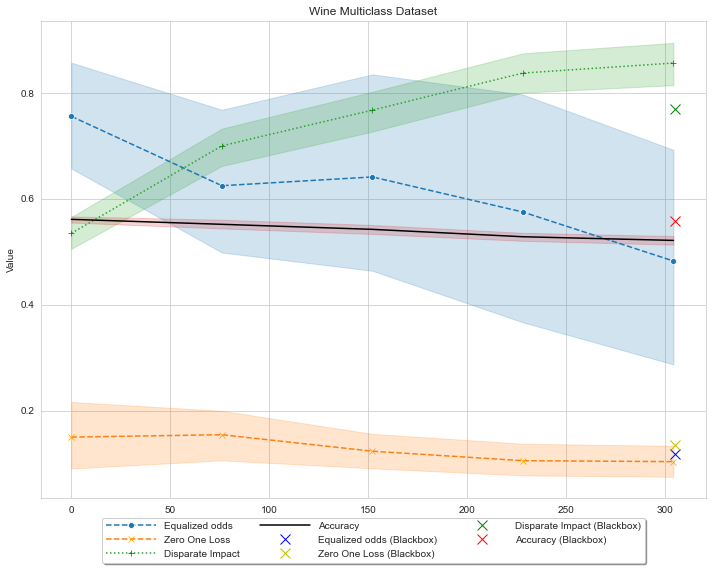

In [18]:
points = preparepoints(blackboxmetrics, 305)

plot_metrics_curves(df, points, 'Wine Multiclass Dataset')


In [19]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 6246
Unprivileged group size: 2052
Percentage of unprivileged group: 32.85302593659942
Number of iterations: 371


In [20]:
save_metrics('blackbox', 'wine', blackboxmetrics)